# Buiding CNN model using keras 

In [1]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, Dropout, Conv2D, Activation, MaxPooling2D

import os
import pandas as pd # some array operation
# from scipy.misc import imread
from skimage import io
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle # Load saved data
import numpy as np # Manipulating with array


Using TensorFlow backend.


In [2]:
# Define data dir path
Train_data_dir = "/Users/york/Tensor1/JupyterNotebook/Ages Classification by Human face image p1/data"
Test_data_dir = "/Users/york/Tensor1/JupyterNotebook/Ages Classification by Human face image p1/data"


# Import csv files
train = pd.read_csv(os.path.join(Train_data_dir, "train_c.csv"))
test = pd.read_csv(os.path.join(Test_data_dir, "test.csv"))

train.head()

train.Class.value_counts()

# np.unique(train.Class)

MIDDLE    10769
YOUNG      6698
OLD        2383
Name: Class, dtype: int64

## Import train and test data

In [3]:
# Import saved data
pickle_in = open(os.path.join(Train_data_dir, "X_train_128x3_c.pickle"),"rb")
train_x = pickle.load(pickle_in)

# Import saved data
pickle_in = open(os.path.join(Train_data_dir, "X_test_128x3_c.pickle"),"rb")
test_x = pickle.load(pickle_in)


# Split off the validation data
train_x, valid_x, train_y, valid_y0 = train_test_split(train_x, train, test_size=0.15, random_state=42)

# Change lable to number
lb = LabelEncoder()
train_y = lb.fit_transform(train_y.Class)
train_y = keras.utils.np_utils.to_categorical(train_y)

valid_y = lb.fit_transform(valid_y0.Class)
valid_y = keras.utils.np_utils.to_categorical(valid_y)


# lb = LabelEncoder()
# test_y = lb.fit_transform(test.Class)
# test_y = keras.utils.np_utils.to_categorical(test_y)

print(train_x.shape)
print(train_y.shape)


print("Train class saperate rate: ")
train.Class.value_counts(normalize=True)

(16872, 128, 128, 3)
(16872, 3)
Train class saperate rate: 


MIDDLE    0.542519
YOUNG     0.337431
OLD       0.120050
Name: Class, dtype: float64

In [4]:
for x in range(6):
    print(train_y[x])

[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]


## Data augmentation using sklearn lib

In [5]:
from keras.preprocessing.image import ImageDataGenerator

data_aug = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 45,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

data_aug.fit(train_x)

### Define parameter using in model

In [6]:
# Define parameter
img_size = 128
chanel_num = 3
class_num = 3

epoch_num = 30
batch_size = 64

# Define weights 
from sklearn.utils import compute_class_weight
# weights = np.zeros(len(train_y))


weights = {
    0:0.19,
    1:0.55,
    2:0.26
}

### Building a cnn model

Using Sequential model with 3 convolutional layers, kernel size is 3x3, stride = 1. Adding 3 dense layers with 0.5 dropout and last layer using 'Softmax' activation function

In [7]:
# Define model
model = Sequential()

# Add 1th layer, convolution 32 neurons with relu activation func
model.add(Conv2D(25,kernel_size=3, strides=1, input_shape=(img_size,img_size,chanel_num)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# Add 2nd convolution layer
model.add(Conv2D(50,kernel_size=3, strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# Add 3nd convolution layer
model.add(Conv2D(75,kernel_size=4, strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Add flatten layer
model.add(Flatten())
# Add normal dense layer with 32 neurons
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Final dense layer are 3 neurons means 3 classes that we have (young, middle, old)
model.add(Dense(3))
# Add final layer activation fuc using softmax
model.add(Activation('softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 64)      

#### Define learning rate schadule

In [8]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.5

# model.compile(tf.keras.optimizers.SGD(), loss='mse')
# round(model.optimizer.lr.numpy(), 5)

# history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
#                     epochs=15, callbacks=[callback], verbose=0)

### Compiling and run the training model

Using Categorical crossentropy loss function, Adam optimizer

In [9]:
# Configure the learning process
from keras.optimizers import SGD, Adadelta, Adam
opt = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
opt1 = Adam(lr=0.0002)
# opt2 = Adadelta(lr=0.001, rho=0.95)
model.compile(loss='categorical_crossentropy',
             optimizer= opt1,
             metrics=['accuracy'])

# Define callback function (lr scheduler)
# callback = keras.callbacks.LearningRateScheduler(scheduler)

# Train the model
history = model.fit_generator(data_aug.flow(train_x, train_y, batch_size=64),
                    steps_per_epoch = len(train_x) / 16,
                    epochs = 20,
                    validation_data=(valid_x,valid_y),
#                     callbacks=[callback],
                    verbose = 1,
                    class_weight = weights)


Epoch 1/26
1055/1054 [==============================] - 579s 549ms/step - loss: 0.2588 - accuracy: 0.5295 - val_loss: 0.8450 - val_accuracy: 0.6014
Epoch 2/26
1055/1054 [==============================] - 465s 440ms/step - loss: 0.2308 - accuracy: 0.5922 - val_loss: 0.7680 - val_accuracy: 0.6420
Epoch 3/26
1055/1054 [==============================] - 466s 442ms/step - loss: 0.2163 - accuracy: 0.6286 - val_loss: 0.6847 - val_accuracy: 0.6985
Epoch 4/26
1055/1054 [==============================] - 495s 469ms/step - loss: 0.2077 - accuracy: 0.6501 - val_loss: 0.7016 - val_accuracy: 0.6837
Epoch 5/26
1055/1054 [==============================] - 33916s 32s/step - loss: 0.1994 - accuracy: 0.6691 - val_loss: 0.6526 - val_accuracy: 0.7189
Epoch 6/26
1055/1054 [==============================] - 5284s 5s/step - loss: 0.1947 - accuracy: 0.6777 - val_loss: 0.6417 - val_accuracy: 0.7220
Epoch 7/26
1055/1054 [==============================] - 1957s 2s/step - loss: 0.1896 - accuracy: 0.6912 - val_los

In [10]:
Score = model.evaluate(valid_x, valid_y, verbose=0)
print("Accuracy: %.2f%%" % (Score[1]*100))

Accuracy: 78.91%


## Show model training plot result

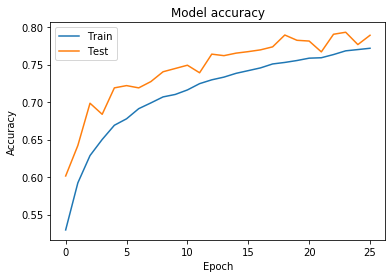

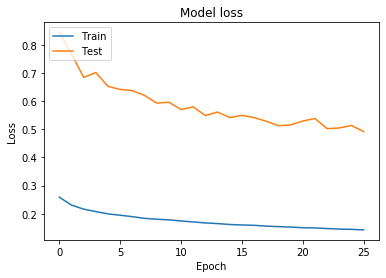

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Generate confusion metrics

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Generate the confusion matrics
valid_pred = model.predict_classes(valid_x)
valid_pred = lb.inverse_transform(valid_pred)

result = confusion_matrix(valid_y0.Class,valid_pred)

print("Confusion matrix :")
print(result)
print("Accuracy: ", accuracy_score(valid_y0.Class,valid_pred))
print("Report: ")
print(classification_report(valid_y0.Class,valid_pred))



Confusion matrix :
[[1182  145  241]
 [  60  287   17]
 [ 134   31  881]]
Accuracy:  0.7891202149093351
Report: 
              precision    recall  f1-score   support

      MIDDLE       0.86      0.75      0.80      1568
         OLD       0.62      0.79      0.69       364
       YOUNG       0.77      0.84      0.81      1046

    accuracy                           0.79      2978
   macro avg       0.75      0.79      0.77      2978
weighted avg       0.80      0.79      0.79      2978



##### Export and save the prediction model and pred result 

In [13]:
# Save the trained model
model.save("ACbyHFI_model10.h5")

# Predict with the test data set and save to csv
pred = model.predict_classes(test_x)
pred = lb.inverse_transform(pred)

test['Class'] = pred
test.to_csv('Testing_Model10.csv', index=False)